In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
# import riiideducation
import random
from sklearn.metrics import roc_auc_score
import gc
import pickle

_ = np.seterr(divide='ignore', invalid='ignore')

In [2]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [3]:
train_df = dt.fread('data/train.csv', columns=set(data_types_dict.keys())).to_pandas()

In [4]:
train_df

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,False,1,1,NaN,NaN
1,56943,115,5716,False,2,1,37000.0,False
2,118363,115,128,False,0,1,55000.0,False
3,131167,115,7860,False,3,1,19000.0,False
4,137965,115,7922,False,4,1,11000.0,False
...,...,...,...,...,...,...,...,...
101230327,428564420,2147482888,3586,False,22,1,18000.0,True
101230328,428585000,2147482888,6341,False,23,1,14000.0,True
101230329,428613475,2147482888,4212,False,24,1,14000.0,True
101230330,428649406,2147482888,6343,False,25,0,22000.0,True


In [5]:
lectures_df = pd.read_csv('data/lectures.csv')

In [6]:
lectures_df

,lecture_id,tag,part,type_of
0,89,24584,5,concept
1,100,22243,1,concept
2,185,7035,6,concept
3,192,31458,5,solving question
4,317,19653,5,solving question
...,...,...,...,...
413,32535,20004,5,solving question
414,32570,4358,3,solving question
415,32604,9093,6,concept
416,32625,23993,2,concept


In [7]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [8]:
part_lectures_columns

['part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7']

In [9]:
types_of_lectures_columns

['type_of_concept',
 'type_of_intention',
 'type_of_solving_question',
 'type_of_starter']

In [10]:
lectures_df

,lecture_id,tag,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,89,24584,0,0,0,0,1,0,0,1,0,0,0
1,100,22243,1,0,0,0,0,0,0,1,0,0,0
2,185,7035,0,0,0,0,0,1,0,1,0,0,0
3,192,31458,0,0,0,0,1,0,0,0,0,1,0
4,317,19653,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,32535,20004,0,0,0,0,1,0,0,0,0,1,0
414,32570,4358,0,0,1,0,0,0,0,0,0,1,0
415,32604,9093,0,0,0,0,0,1,0,1,0,0,0
416,32625,23993,0,1,0,0,0,0,0,1,0,0,0


In [11]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [12]:
train_lectures

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,653762,2746,6808,True,14,-1,NaN,False,6808,21858,...,1,0,0,0,0,0,0,1,0,0
1,10183847,5382,16736,True,21,-1,NaN,False,16736,1278,...,0,0,0,0,0,0,1,0,0,0
2,1424348597,5382,30207,True,104,-1,NaN,False,30207,9727,...,0,0,0,1,0,0,1,0,0,0
3,1425557777,5382,18545,True,121,-1,NaN,False,18545,25943,...,0,0,0,1,0,0,1,0,0,0
4,405813029,8623,10540,True,59,-1,NaN,False,10540,22856,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959027,132157858,2147482216,14325,True,38,-1,NaN,False,14325,32082,...,1,0,0,0,0,0,0,1,0,0
1959028,1073593458,2147482216,21887,True,170,-1,NaN,False,21887,23274,...,1,0,0,0,0,0,1,0,0,0
1959029,1240316256,2147482216,6808,True,193,-1,NaN,False,6808,21858,...,1,0,0,0,0,0,0,1,0,0
1959030,1240470616,2147482216,27699,True,195,-1,NaN,False,27699,21858,...,1,0,0,0,0,0,0,1,0,0


In [13]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [14]:
user_lecture_stats_part

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,2746,0,1,0,0,0,0,0,0,1,0,0
1,5382,1,0,0,0,2,0,0,3,0,0,0
2,8623,2,1,0,0,0,0,0,3,0,0,0
3,12741,0,0,0,3,0,1,2,4,0,2,0
4,13134,1,3,0,0,3,0,0,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
149601,2147419988,4,0,1,0,18,21,0,27,0,17,0
149602,2147469944,1,0,0,1,1,0,0,3,0,0,0
149603,2147470770,0,0,0,0,2,0,0,2,0,0,0
149604,2147470777,0,0,0,3,3,0,0,6,0,0,0


In [15]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)


In [16]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [17]:
user_lecture_stats_part.dtypes

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object

In [18]:
del(train_lectures)

In [19]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['user_lecture_cumsum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']

train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_cumsum=train_df.user_lecture_cumsum.astype('int8')
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])

In [20]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [21]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
max_timestamp_u.columns = ['user_id', 'max_time_stamp']

In [22]:
max_timestamp_u

,user_id,max_time_stamp
0,115,668090043
1,124,571323
2,2746,835457
3,5382,2101551456
4,8623,862338736
...,...,...
393651,2147470770,2832089444
393652,2147470777,13332685203
393653,2147481750,55954768
393654,2147482216,1470594073


In [23]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
train_df['lagtime'].fillna(0, inplace=True)
train_df.lagtime=train_df.lagtime.astype('int32')
#train_df.drop(columns=['timestamp'], inplace=True)

In [24]:
train_df

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,lagtime
0,0,115,5692,0,1,1,25423.853516,False,0,NaN,0
1,56943,115,5716,0,2,1,37000.000000,False,0,0.0,56943
2,118363,115,128,0,0,1,55000.000000,False,0,0.0,61420
3,131167,115,7860,0,3,1,19000.000000,False,0,0.0,12804
4,137965,115,7922,0,4,1,11000.000000,False,0,0.0,6798
...,...,...,...,...,...,...,...,...,...,...,...
99271295,428564420,2147482888,3586,0,22,1,18000.000000,True,0,0.0,21548
99271296,428585000,2147482888,6341,0,23,1,14000.000000,True,0,0.0,20580
99271297,428613475,2147482888,4212,0,24,1,14000.000000,True,0,0.0,28475
99271298,428649406,2147482888,6343,0,25,0,22000.000000,True,0,0.0,35931


In [25]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
train_df.lagtime_mean=train_df.lagtime_mean.astype('int32')


In [26]:
lagtime_agg

,mean
user_id,
115,1.452370e+07
124,1.904410e+04
2746,4.397142e+04
5382,1.681241e+07
8623,7.911365e+06
...,...
2147470770,1.253137e+07
2147470777,-4.508823e+06
2147481750,1.119095e+06


In [27]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1) # tail()がないとpandas object表示のままで 1 は最初の行を抜いている
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [28]:
user_prior_question_elapsed_time

,user_id,prior_question_elapsed_time
45,115,14333.0
75,124,6500.0
94,2746,20000.0
219,5382,22000.0
328,8623,18000.0
...,...,...
99270195,2147470770,27000.0
99270947,2147470777,22666.0
99270997,2147481750,21000.0
99271272,2147482216,14000.0


In [29]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']
train_df['delta_prior_question_elapsed_time'].fillna(0, inplace=True)

In [30]:
train_df

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,lagtime,lagtime_mean,delta_prior_question_elapsed_time
0,0,115,5692,0,1,1,25423.853516,False,0,NaN,0,14523696,0.000000
1,56943,115,5716,0,2,1,37000.000000,False,0,0.0,56943,14523696,11576.146484
2,118363,115,128,0,0,1,55000.000000,False,0,0.0,61420,14523696,18000.000000
3,131167,115,7860,0,3,1,19000.000000,False,0,0.0,12804,14523696,-36000.000000
4,137965,115,7922,0,4,1,11000.000000,False,0,0.0,6798,14523696,-8000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,428564420,2147482888,3586,0,22,1,18000.000000,True,0,0.0,21548,15877485,-26000.000000
99271296,428585000,2147482888,6341,0,23,1,14000.000000,True,0,0.0,20580,15877485,-4000.000000
99271297,428613475,2147482888,4212,0,24,1,14000.000000,True,0,0.0,28475,15877485,0.000000
99271298,428649406,2147482888,6343,0,25,0,22000.000000,True,0,0.0,35931,15877485,8000.000000


In [31]:
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [32]:
train_df['timestamp']=train_df['timestamp']/(1000*3600) # 1000ミリ秒なので時間に直すときはかける
train_df.timestamp=train_df.timestamp.astype('int16')

In [33]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

# train_df['user_correctness'].fillna(1, inplace=True)
train_df['user_correct_cumsum'].fillna(0, inplace=True)
#train_df['user_correct_cumcount'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_cumcount=train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum=train_df.user_correct_cumsum.astype('int16')

In [34]:
cum

,cumsum,cumcount
0,NaN,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
...,...,...
99271295,11.0,22
99271296,12.0,23
99271297,13.0,24
99271298,14.0,25


In [35]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')

train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()

In [36]:
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 
train_df.drop(columns=['lag'], inplace=True)

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [37]:
train_df

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,lagtime,lagtime_mean,delta_prior_question_elapsed_time,user_correctness,user_correct_cumsum,user_correct_cumcount,explanation_mean,explanation_cumsum
0,0,115,5692,0,1,1,25423.853516,0,0,NaN,0,14523696,0,NaN,0,0,0.000000,0
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,56943,14523696,11576,1.000000,1,1,0.000000,0
2,0,115,128,0,0,1,55000.000000,0,0,0.0,61420,14523696,18000,1.000000,2,2,0.000000,0
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,12804,14523696,-36000,1.000000,3,3,0.000000,0
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,6798,14523696,-8000,1.000000,4,4,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,119,2147482888,3586,0,22,1,18000.000000,1,0,0.0,21548,15877485,-26000,0.500000,11,22,0.636230,14
99271296,119,2147482888,6341,0,23,1,14000.000000,1,0,0.0,20580,15877485,-4000,0.521973,12,23,0.652344,15
99271297,119,2147482888,4212,0,24,1,14000.000000,1,0,0.0,28475,15877485,0,0.541504,13,24,0.666504,16
99271298,119,2147482888,6343,0,25,0,22000.000000,1,0,0.0,35931,15877485,8000,0.560059,14,25,0.680176,17


In [38]:
del cum
gc.collect()

160

In [39]:
train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [40]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,lagtime,lagtime_mean,delta_prior_question_elapsed_time,user_correctness,user_correct_cumsum,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no
0,0,115,5692,0,1,1,25423.853516,0,0,NaN,0,14523696,0,NaN,0,0,0.0,0,1
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,56943,14523696,11576,1.0,1,1,0.0,0,1
2,0,115,128,0,0,1,55000.000000,0,0,0.0,61420,14523696,18000,1.0,2,2,0.0,0,1
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,12804,14523696,-36000,1.0,3,3,0.0,0,1
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,6798,14523696,-8000,1.0,4,4,0.0,0,1


In [41]:
train_df.dtypes

timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
dtype: object

In [42]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg = explanation_agg.astype('int16')

In [43]:
explanation_agg

,sum,count
user_id,,
115,6,46
124,0,30
2746,11,19
5382,113,125
8623,96,109
...,...,...
2147470770,195,226
2147470777,721,752
2147481750,39,50


In [44]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])

In [45]:
user_agg=user_agg.astype('int16')
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [46]:
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
attempt_no_agg=attempt_no_agg.astype('int8')

In [47]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness=train_df.content_correctness.astype('float16')
train_df['task_container_sum'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [48]:
train_df

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,...,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no,content_count,content_sum,content_correctness,task_container_sum,task_container_std,task_container_correctness
0,0,115,5692,0,1,1,25423.853516,0,0,NaN,...,0,0.000000,0,1,36514,27221,0.745605,208704,0.249268,0.527344
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,...,1,0.000000,0,1,23991,17631,0.734863,172342,0.245850,0.435791
2,0,115,128,0,0,1,55000.000000,0,0,0.0,...,2,0.000000,0,1,19619,18969,0.966797,269233,0.217651,0.680176
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,...,3,0.000000,0,1,21733,20751,0.954590,214721,0.248169,0.542969
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,...,4,0.000000,0,1,19409,18501,0.953125,330079,0.249512,0.477051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,119,2147482888,3586,0,22,1,18000.000000,1,0,0.0,...,22,0.636230,14,1,4364,3234,0.741211,166774,0.235962,0.618652
99271296,119,2147482888,6341,0,23,1,14000.000000,1,0,0.0,...,23,0.652344,15,1,10220,5394,0.527832,161481,0.238770,0.605957
99271297,119,2147482888,4212,0,24,1,14000.000000,1,0,0.0,...,24,0.666504,16,1,31415,19358,0.616211,165255,0.235107,0.622070
99271298,119,2147482888,6343,0,25,0,22000.000000,1,0,0.0,...,25,0.680176,17,1,5752,3806,0.661621,161824,0.237305,0.612793


In [49]:
questions_df = pd.read_csv(
    'data/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')
tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']


tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [50]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [51]:
questions_df

,content_id,bundle_id,part,part_bundle_id,tags1,tags2,tags3,tags4,tags5,tags6
0,0,0,1,100000,51,131,162,38,0,0
1,1,1,1,100001,131,36,81,0,0,0
2,2,2,1,100002,131,101,162,92,0,0
3,3,3,1,100003,131,149,162,29,0,0
4,4,4,1,100004,131,5,162,38,0,0
...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,5,513518,14,0,0,0,0,0
13519,13519,13519,5,513519,8,0,0,0,0,0
13520,13520,13520,5,513520,73,0,0,0,0,0
13521,13521,13521,5,513521,125,0,0,0,0,0


In [52]:
content_agg

,sum,count,var
content_id,,,
0,6266.0,6903.0,0.083775
1,6589.0,7398.0,0.097409
2,24890.0,44905.0,0.247059
3,17906.0,22973.0,0.171923
4,19461.0,31736.0,0.237190
...,...,...,...
13518,683.0,868.0,0.167901
13519,528.0,924.0,0.245163
13520,579.0,861.0,0.220509


In [53]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')

In [54]:
questions_df

,content_id,bundle_id,part,part_bundle_id,tags1,tags2,tags3,tags4,tags5,tags6,content_correctness,content_correctness_std
0,0,0,1,100000,51,131,162,38,0,0,0.907715,0.083801
1,1,1,1,100001,131,36,81,0,0,0,0.890625,0.097412
2,2,2,1,100002,131,101,162,92,0,0,0.554199,0.247070
3,3,3,1,100003,131,149,162,29,0,0,0.779297,0.171875
4,4,4,1,100004,131,5,162,38,0,0,0.613281,0.237183
...,...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,5,513518,14,0,0,0,0,0,0.787109,0.167847
13519,13519,13519,5,513519,8,0,0,0,0,0,0.571289,0.245117
13520,13520,13520,5,513520,73,0,0,0,0,0,0.672363,0.220459
13521,13521,13521,5,513521,125,0,0,0,0,0,0.808105,0.155273


In [55]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [56]:
questions_df

,content_id,bundle_id,part,part_bundle_id,tags1,tags2,tags3,tags4,tags5,tags6,content_correctness,content_correctness_std,part_correctness_mean,part_correctness_std
0,0,0,1,100000,51,131,162,38,0,0,0.907715,0.083801,0.814941,0.021591
1,1,1,1,100001,131,36,81,0,0,0,0.890625,0.097412,0.814941,0.021591
2,2,2,1,100002,131,101,162,92,0,0,0.554199,0.247070,0.814941,0.021591
3,3,3,1,100003,131,149,162,29,0,0,0.779297,0.171875,0.814941,0.021591
4,4,4,1,100004,131,5,162,38,0,0,0.613281,0.237183,0.814941,0.021591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,5,513518,14,0,0,0,0,0,0.787109,0.167847,0.666016,0.024445
13519,13519,13519,5,513519,8,0,0,0,0,0,0.571289,0.245117,0.666016,0.024445
13520,13520,13520,5,513520,73,0,0,0,0,0,0.672363,0.220459,0.666016,0.024445
13521,13521,13521,5,513521,125,0,0,0,0,0,0.808105,0.155273,0.666016,0.024445


In [57]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness=questions_df.bundle_correctness.astype('float16')

In [58]:
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['mean', 'var'])
questions_df['tags1_correctness_mean'] = questions_df['tags1'].map(tags1_agg['mean'])
questions_df['tags1_correctness_std'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_correctness_mean=questions_df.tags1_correctness_mean.astype('float16')
questions_df.tags1_correctness_std=questions_df.tags1_correctness_std.astype('float16')

In [59]:
questions_df.drop(columns=['content_correctness'], inplace=True)

In [60]:
questions_df.dtypes

content_id                   int16
bundle_id                    int16
part                          int8
part_bundle_id               int32
tags1                        int16
tags2                        int16
tags3                        int16
tags4                        int16
tags5                        int16
tags6                        int16
content_correctness_std    float16
part_correctness_mean      float16
part_correctness_std       float16
bundle_correctness         float16
tags1_correctness_mean     float16
tags1_correctness_std      float16
dtype: object

In [61]:
del bundle_agg
del part_agg
del tags1_agg
gc.collect()

72

In [62]:
len(train_df)

99271300

In [63]:
train_df['user_correctness'].fillna( 1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)

train_df.fillna(0, inplace=True)

In [64]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_lecture_cumsum,user_lecture_lv,...,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no,content_count,content_sum,content_correctness,task_container_sum,task_container_std,task_container_correctness
0,0,115,5692,0,1,1,25423.853516,0,0,0.0,...,0,0.0,0,1,36514,27221,0.745605,208704,0.249268,0.527344
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,...,1,0.0,0,1,23991,17631,0.734863,172342,0.245850,0.435791
2,0,115,128,0,0,1,55000.000000,0,0,0.0,...,2,0.0,0,1,19619,18969,0.966797,269233,0.217651,0.680176
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,...,3,0.0,0,1,21733,20751,0.954590,214721,0.248169,0.542969
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,...,4,0.0,0,1,19409,18501,0.953125,330079,0.249512,0.477051


In [65]:
train_df.dtypes

timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
content_count                          int32
content_sum                            int32
content_correctness                  float16
task_conta

In [66]:
# ユーザーIDごとにまとめられたコンテンツIDとユーザーの答えが当たっているかどうか（MAX_SEQで大きさの制御も）
MAX_SEQ = 160

skills = train_df["content_id"].unique()
n_skill = len(skills)
print("number skills", len(skills))

group = train_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))

for user_id in group.index:
    q, qa = group[user_id]
    if len(q)>MAX_SEQ:
        group[user_id] = (q[-MAX_SEQ:],qa[-MAX_SEQ:]) # 後ろから数えてMAX_SEQまで、つまりMAX_SEQを超えたら前が消される
        
pickle.dump(group, open("data/group.pkl", "wb"))
del group
gc.collect()


number skills 13523


0

In [67]:
with open('data/group.pkl', 'rb') as load_test:
  load_test = pickle.load(load_test)
  print(load_test)

user_id
115           ([5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...
124           ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
2746          ([5273, 758, 5976, 236, 404, 382, 405, 873, 53...
5382          ([5000, 3944, 217, 5844, 5965, 4990, 5235, 605...
8623          ([3915, 4750, 6456, 3968, 6104, 5738, 6435, 54...
                                    ...                        
2147470770    ([697, 502, 946, 10685, 4664, 4476, 5247, 9161...
2147470777    ([6487, 6843, 6844, 6842, 6841, 6827, 6826, 68...
2147481750    ([4137, 1270, 9261, 8201, 367, 378, 214, 6071,...
2147482216    ([6388, 6025, 6075, 9968, 3913, 6155, 5593, 95...
2147482888    ([6147, 4792, 5738, 6102, 4748, 7956, 6435, 92...
Length: 393656, dtype: object


In [68]:
print(load_test[115])

(array([5692, 5716,  128, 7860, 7922,  156,   51,   50, 7896, 7863,  152,
        104,  108, 7900, 7901, 7971,   25,  183, 7926, 7927,    4, 7984,
         45,  185,   55, 7876,    6,  172, 7898,  175,  100, 7859,   57,
       7948,  151,  167, 7897, 7882, 7962, 1278, 2065, 2064, 2063, 3363,
       3365, 3364], dtype=int16), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1], dtype=int8))


In [69]:
del load_test 
gc.collect()

40

In [70]:
features = [
#   'user_id',
#HDKIM    'timestamp',
    'lagtime',
    'lagtime_mean',
   # 'content_id',
   # 'task_container_id',
    'user_lecture_cumsum', # X
    'user_lecture_lv',
    'prior_question_elapsed_time',
    'delta_prior_question_elapsed_time',
    'user_correctness',
    'user_correct_cumcount', #X
    'user_correct_cumsum', #X
    'content_correctness',
   # 'content_correctness_std',
    'content_count',
    'content_sum', #X
    'task_container_correctness',
   # 'task_container_std',
   # 'task_container_sum',
    'bundle_correctness',
    'attempt_no',
    'part',
    'part_correctness_mean',
   # 'part_correctness_std',
    'tags1',
    'tags1_correctness_mean',
      #  'tags1_correctness_std',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
  #  'part_bundle_id',
    'explanation_mean', 
    'explanation_cumsum',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]

In [71]:
categorical_columns= [
#   'user_id',
  #  'content_id',
  # 'task_container_id',
    'part',        
    'tags1',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
   # 'part_bundle_id',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]

In [72]:
flag_lgbm=True
clfs = list()
params = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
#'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}

In [73]:
trains=list()
valids=list()
num=1
for i in range(0,num):
  
    #train_df=train_df.reset_index(drop=True)
    train_df_clf=train_df.sample(n=20000*1000)
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
   
    del train_df
    
    users=train_df_clf['user_id'].drop_duplicates()#去重
    
    users=users.sample(frac=0.025)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
  
  
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    #
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
   
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)#
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#
    
#     train_df_clf = pd.merge(train_df_clf, user_lecture_stats_part, on='user_id', how="left",right_index=True)
#     valid_df_newuser = pd.merge(valid_df_newuser, user_lecture_stats_part, on='user_id', how="left",right_index=True)

    valid_df=train_df_clf.sample(frac=0.09)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('train_df length:', len(train_df_clf))
    print('valid_df length：',len(valid_df))
    #train_df=train_df.reset_index(drop=True)

sample end
train_df length: 17757590
valid_df length： 2242410


In [74]:
del train_df_clf
del valid_df
gc.collect()

20

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.756065	valid_1's auc: 0.75398
[20]	training's auc: 0.762704	valid_1's auc: 0.760513
[30]	training's auc: 0.765853	valid_1's auc: 0.763474
[40]	training's auc: 0.767342	valid_1's auc: 0.764624
[50]	training's auc: 0.769335	valid_1's auc: 0.766031
[60]	training's auc: 0.771025	valid_1's auc: 0.767291
[70]	training's auc: 0.772374	valid_1's auc: 0.768264
[80]	training's auc: 0.773661	valid_1's auc: 0.768967
[90]	training's auc: 0.775218	valid_1's auc: 0.769718
[100]	training's auc: 0.776441	valid_1's auc: 0.770327
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.776441	valid_1's auc: 0.770327


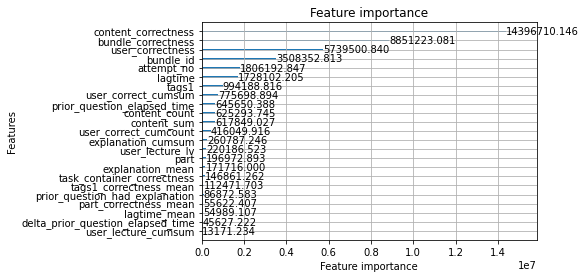

In [75]:
for i in range(0,num):
   
    tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
    va_data = lgb.Dataset(valids[i][features], label=valids[i][target])
    
#     del train_df_clf
#     del valid_df
#     gc.collect()
    del trains
    del valids
    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
#         train_df[features],
#         train_df[target],
        num_boost_round=100,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=10,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=10
    )
    clfs.append(model)
    #print('auc:', roc_auc_score(valid_df[target], model.predict(valid_df[features])))
    #model.save_model(f'model.txt')
    lgb.plot_importance(model, importance_type='gain')
    plt.show()

    del tr_data
    del va_data
    gc.collect()
#    
# del trains
# del valids
# gc.collect()